In [19]:
# set up spark
import sys
from os import listdir
from os.path import join,exists
pyspark_home = '/home/gaoxiang/apps/spark/python/lib'
zipfiles = [join(pyspark_home, f) for f in listdir(pyspark_home) if f.endswith('.zip')]
sys.path += zipfiles
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
%pylab inline

path = '/home/gaoxiang/MEGA/tables'

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean', 'rint', 'colors', 'hypot', 'log10', 'log', 'repeat', 'sinh', 'rand', 'size', 'expm1', 'ceil', 'randn', 'sqrt', 'radians', 'cos', 'rank', 'cbrt', 'cosh', 'trunc', 'exp', 'floor', 'isnan', 'degrees', 'split', 'array', 'tan', 'sum', 'log1p', 'sin', 'broadcast', 'log2', 'tanh']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [20]:
distances = spark.read.parquet(path+'/distances')
thexpvec = spark.read.parquet(path+'/thexpvec')

10786


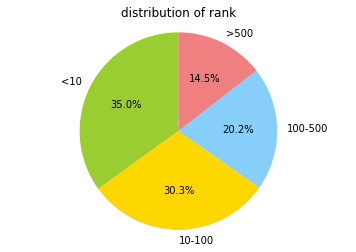

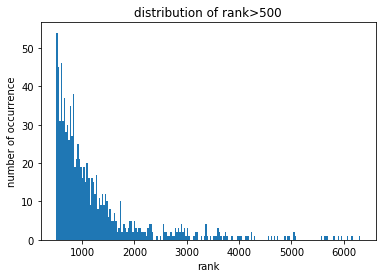

+----+-----+
|rank|count|
+----+-----+
|   0|  867|
|   1|  375|
|   2|  237|
|   3|  195|
|   4|  145|
|   5|  124|
|   6|  130|
|   7|  102|
|   8|   78|
|   9|   78|
|  10|   80|
|  11|   66|
|  12|   72|
|  13|   61|
|  14|   48|
|  15|   46|
|  16|   45|
|  17|   59|
|  18|   47|
|  19|   46|
+----+-----+
only showing top 20 rows



In [21]:
count = thexpvec.count()
ranks = distances.select('rank')
print(count)

labels = '<10', '10-100', '100-500', '>500'
sizes = [ ranks.filter("rank<10").count(),
          ranks.filter("rank>=10 and rank<100").count(),
          ranks.filter("rank>100 and rank<500").count(),
          ranks.filter("rank>500").count() ]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'magenta']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('distribution of rank')
plt.show()

local = ranks.filter("rank > 500").collect()
rank = [row['rank'] for row in local]
fig,ax = plt.subplots()
plt.hist(rank,200)
# fig.set_size_inches(15, 10)
plt.title("distribution of rank>500")
plt.xlabel("rank")
plt.ylabel("number of occurrence")
plt.show()
ranks.groupBy('rank').count().sort('rank').show()

+---------+--------------------+----+---------+--------------------+--------------------+
|      mid|              smiles|rank|rankrange|              expvec|               thvec|
+---------+--------------------+----+---------+--------------------+--------------------+
|  C103059|  CC(C)(O)CCc1ccccc1|   0|        0|[0.06436762924444...|[0.52070387525748...|
|  C592881|           C=CCSCC=C|   1|        1|[0.03134251208038...|[0.06107973521844...|
|  C712505|O=C(c1ccccc1)C1CC...|   2|        2|[0.24325696576091...|[0.98956131088568...|
|C36377590|  CCOc1ccc(CCN)cc1OC|   6|        3|[0.01708340613943...|[0.22519244398579...|
|  C135773|  COc1ccc(OC)c(OC)c1|   7|        4|[0.03067097317510...|[0.28400606714005...|
| C1009116| CCCC(=O)c1ccc(O)cc1|  13|        5|[0.01631046310512...|[0.13018731331211...|
| C3683123|C=C(C)C(=O)OCCc1c...|  22|        6|[0.01967202148253...|[0.63178007116193...|
|   C71410|              CCCCCO|  41|        7|[0.11580837089350...|[0.03034851518717...|
|  C926567

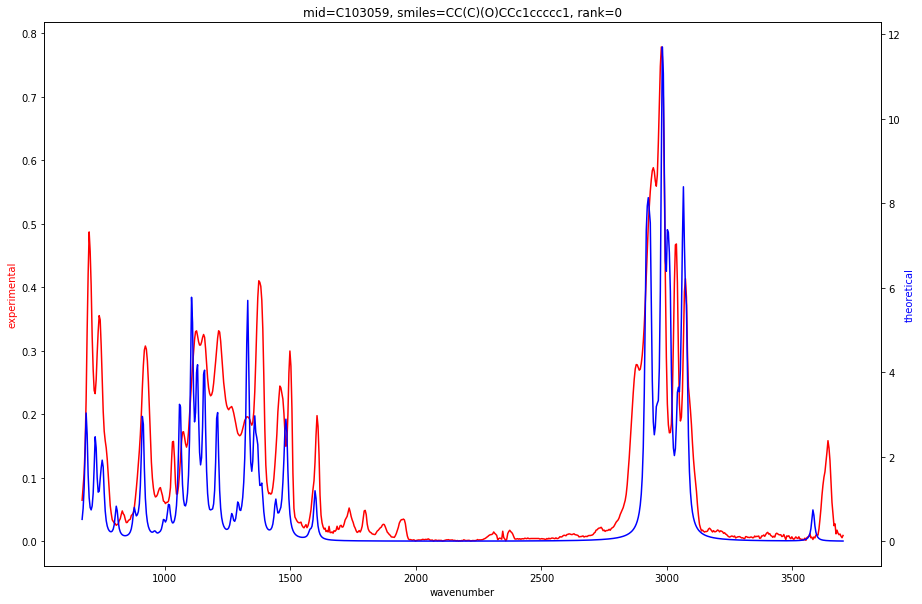

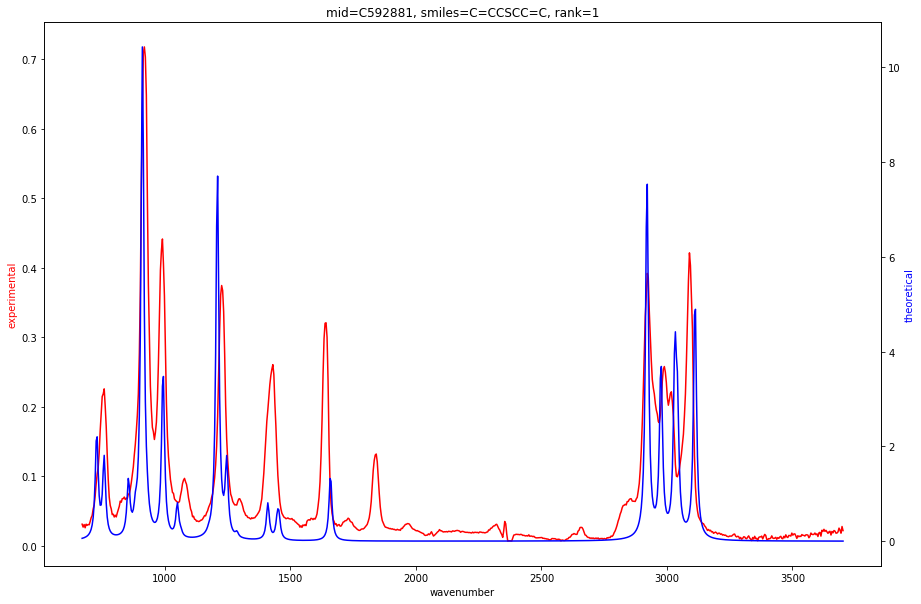

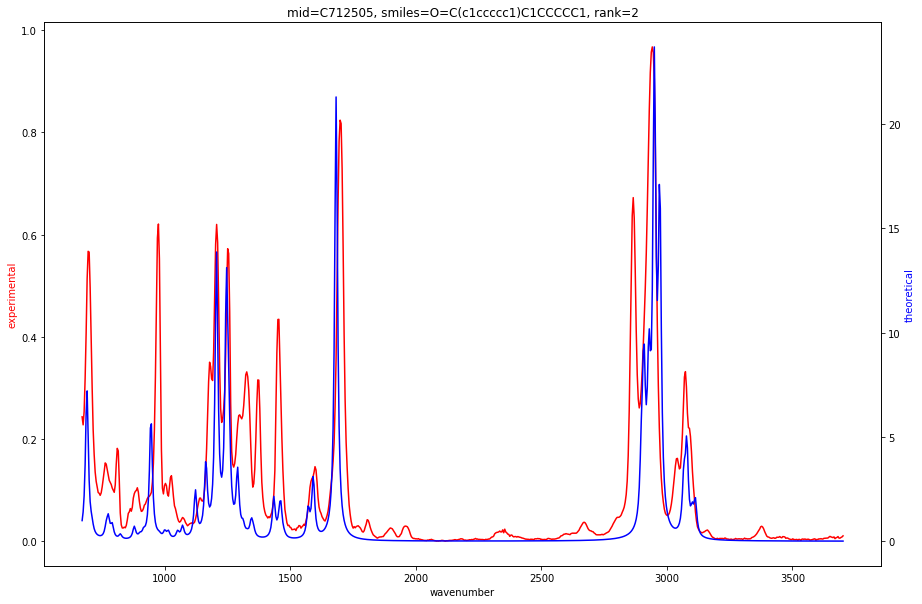

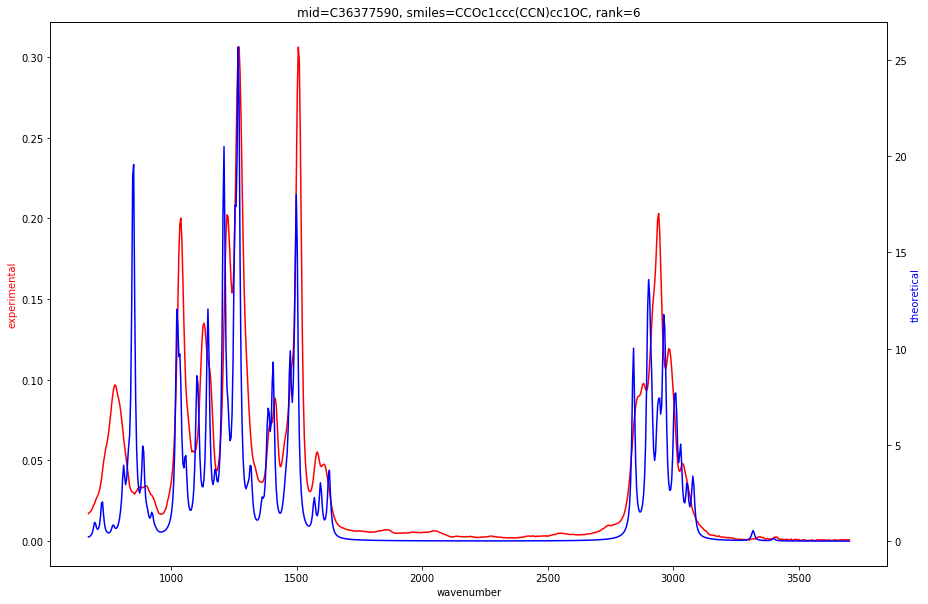

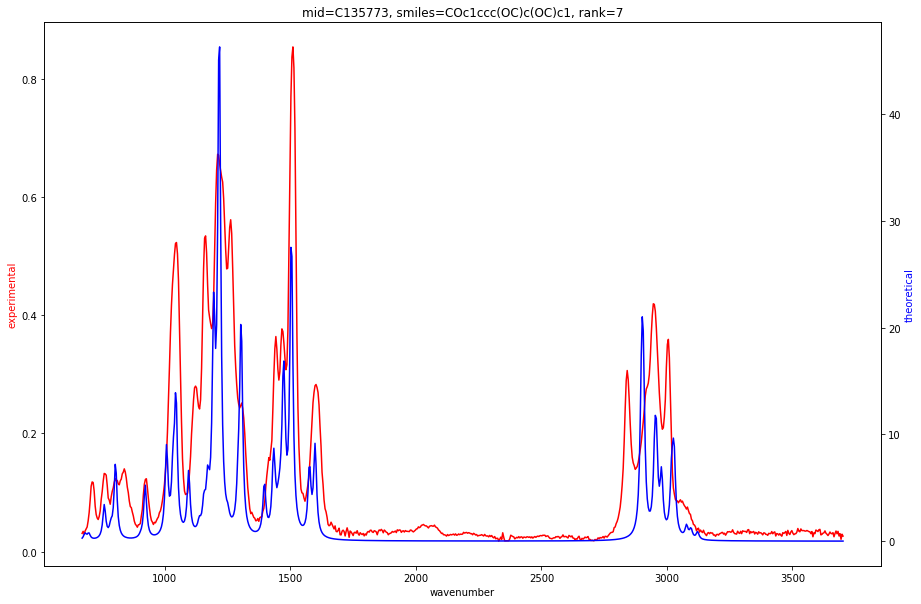

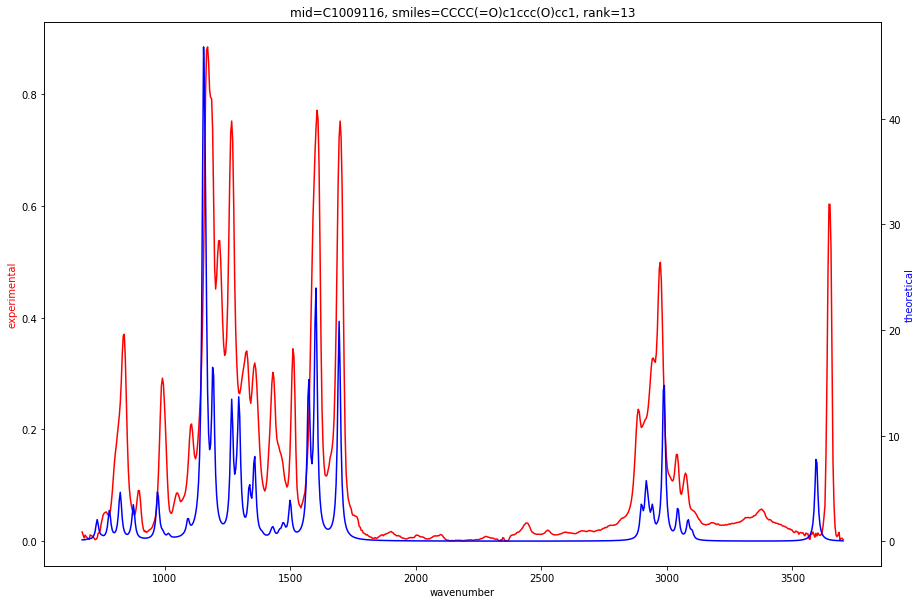

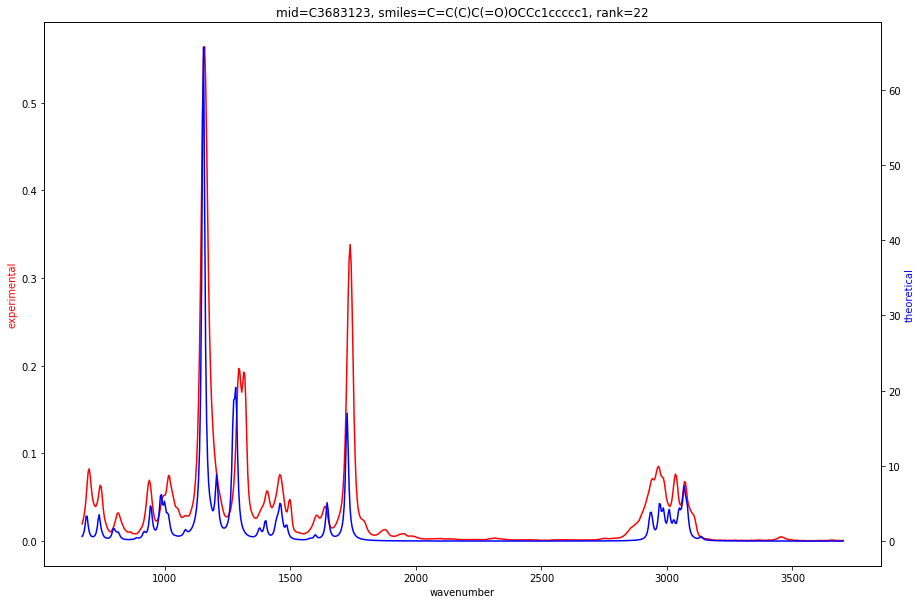

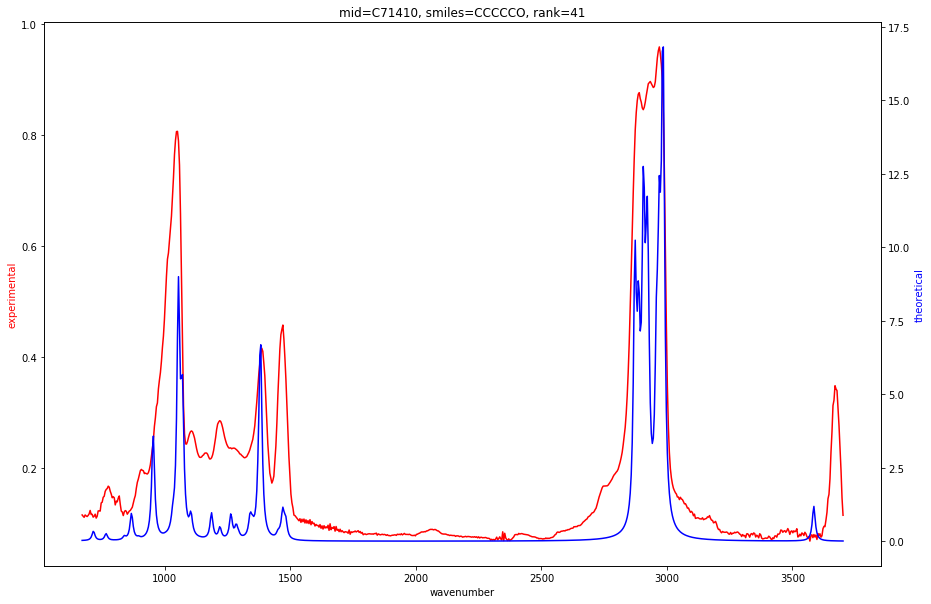

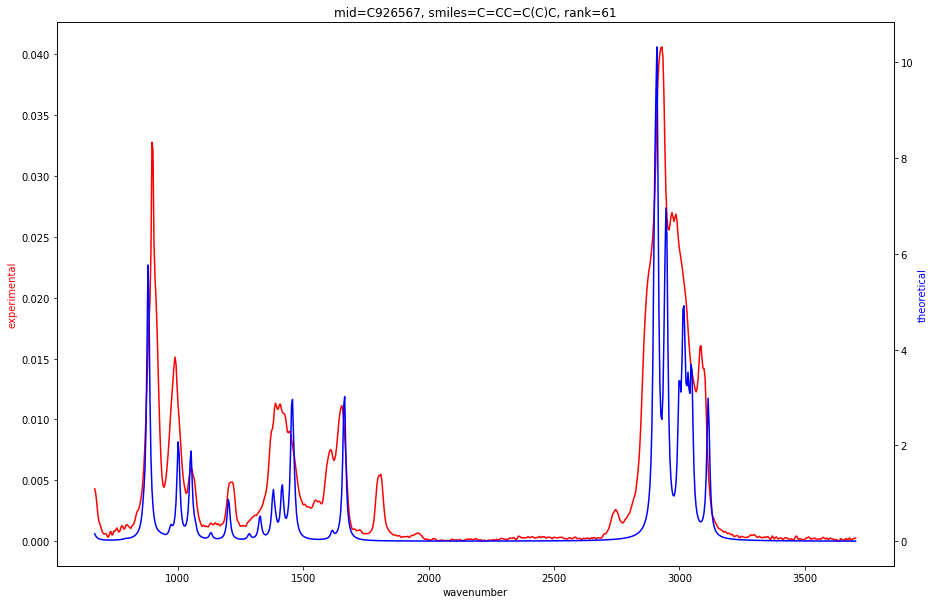

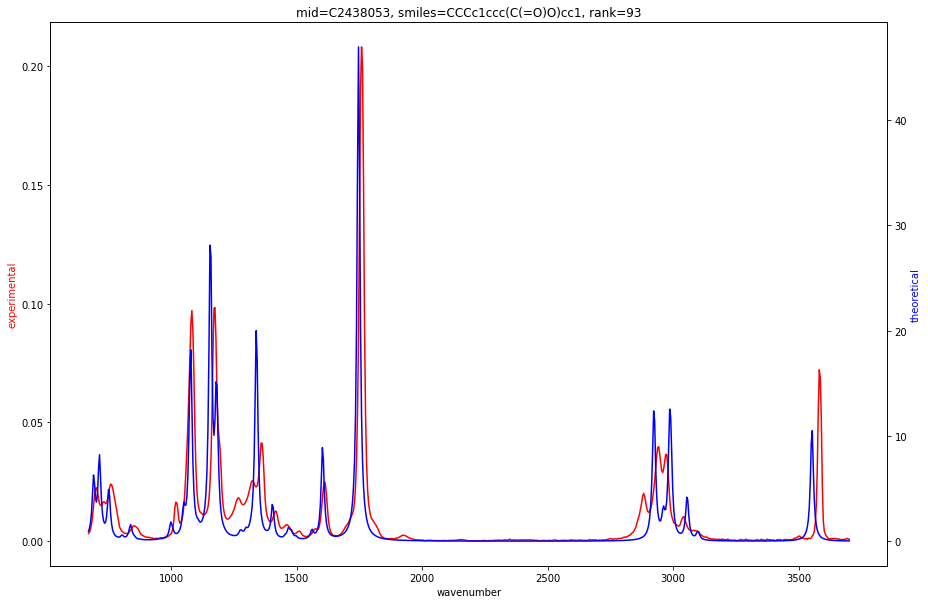

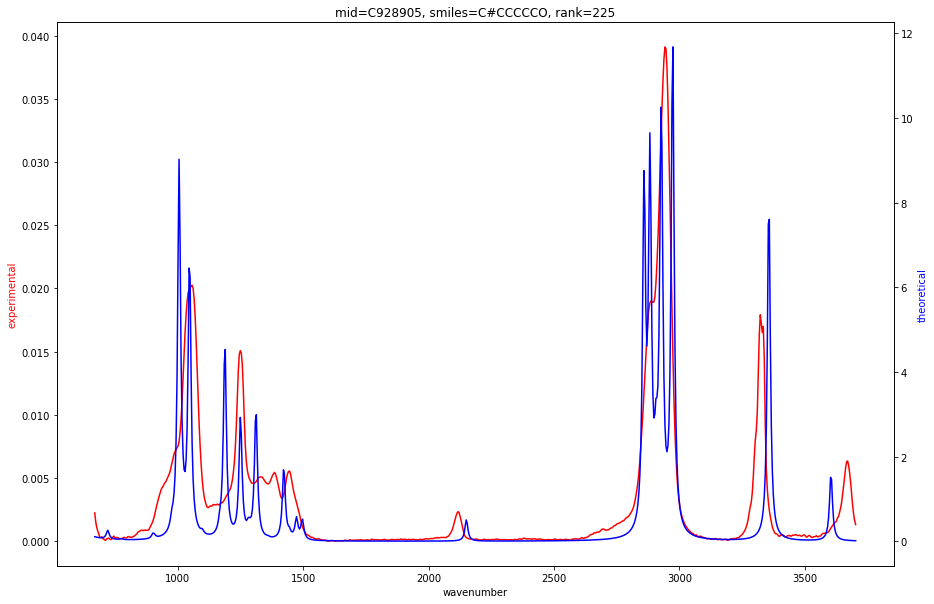

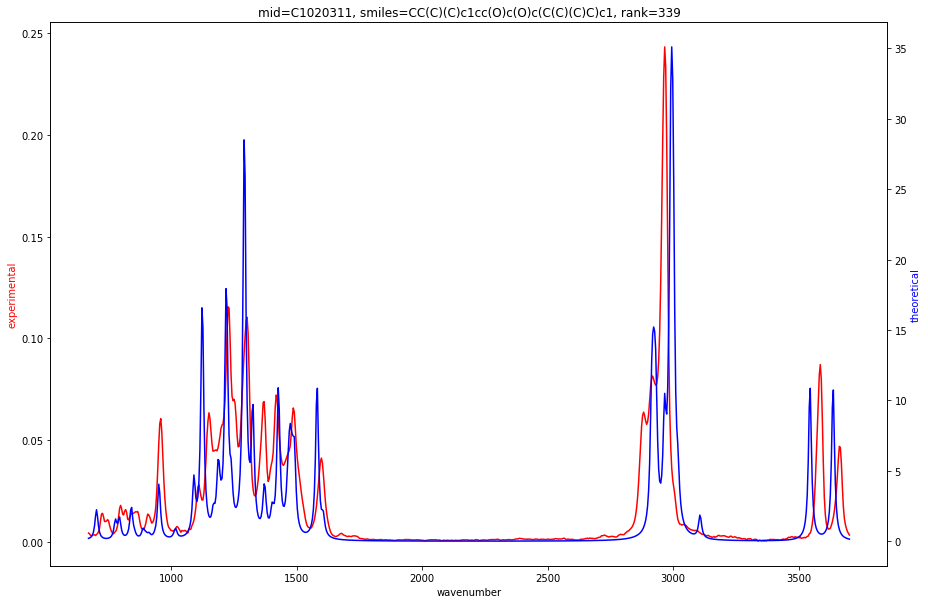

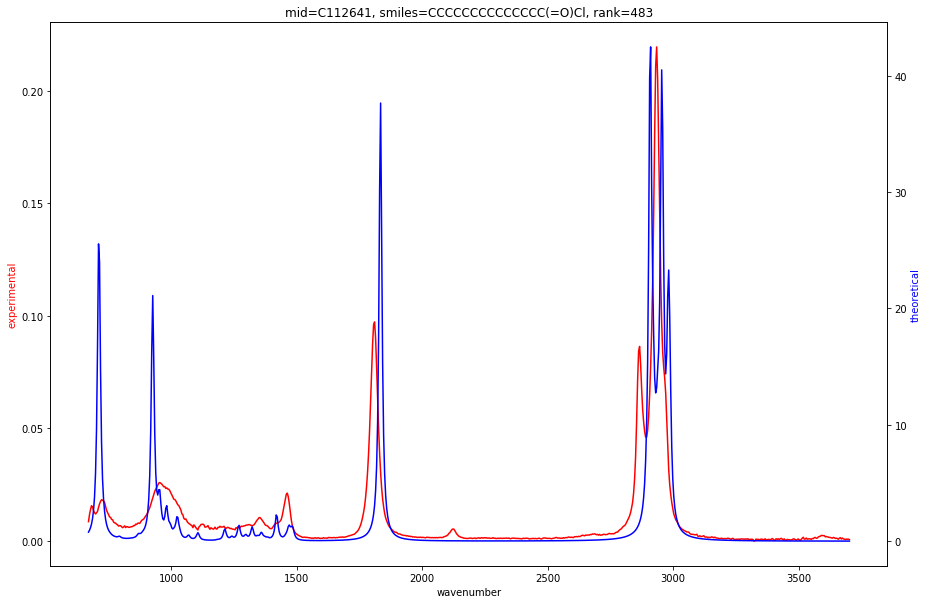

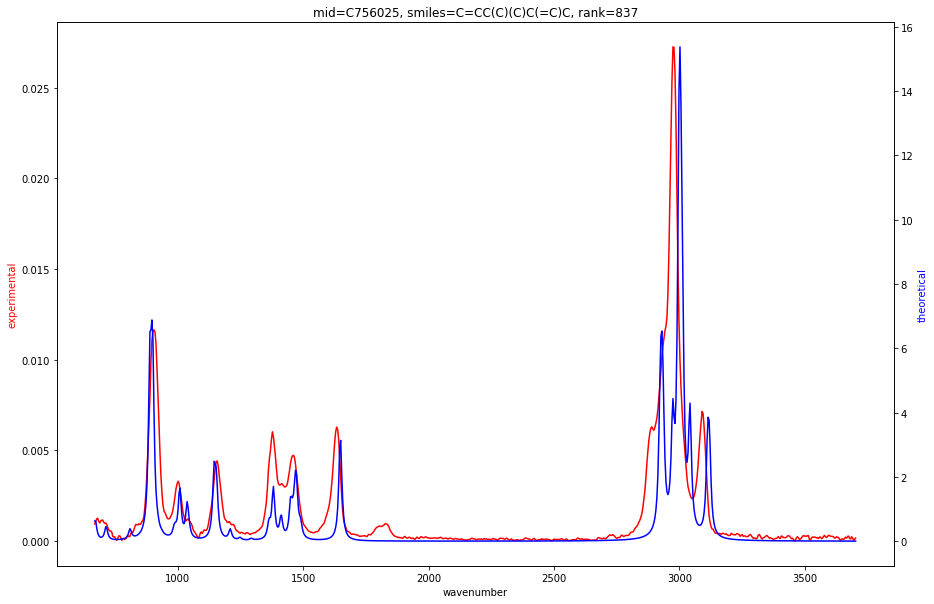

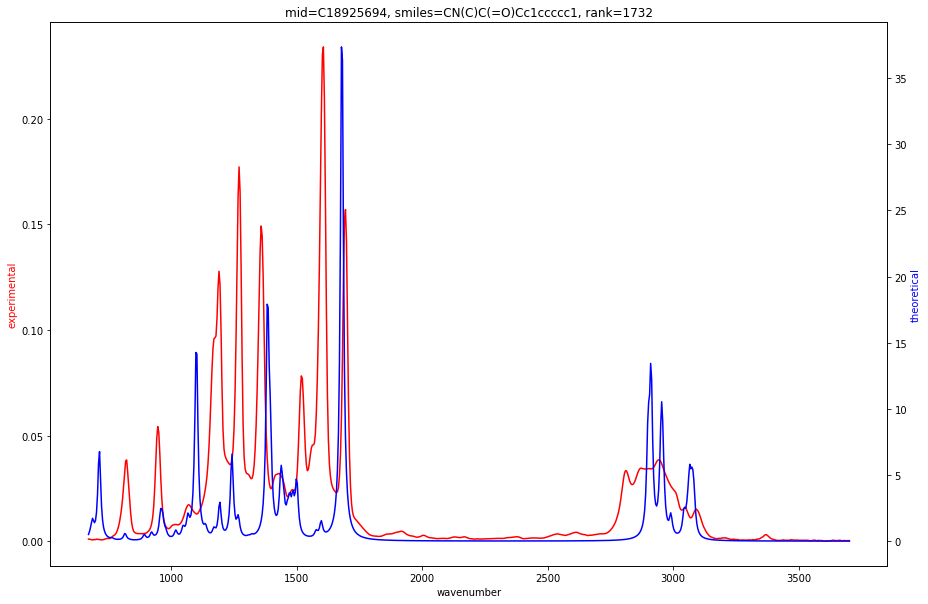

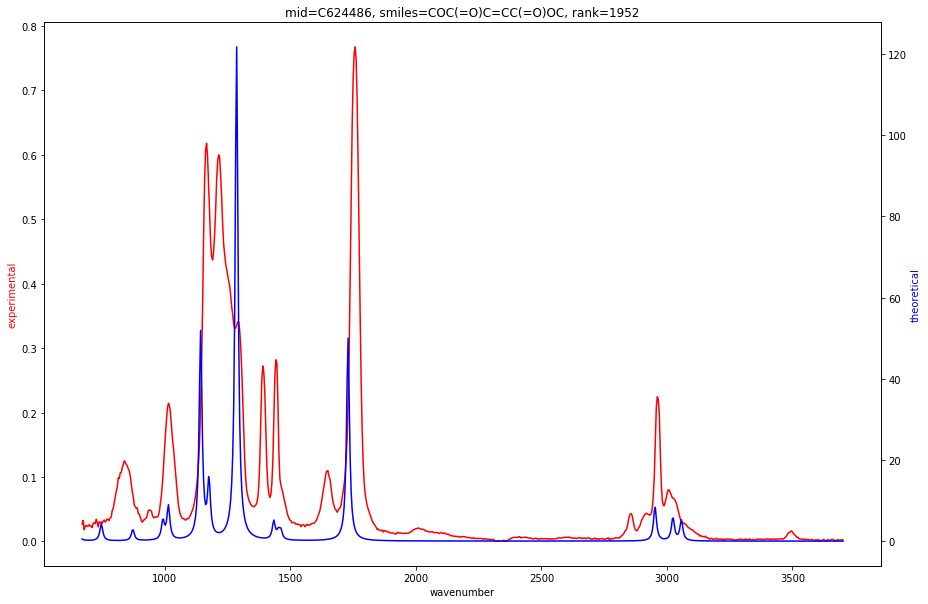

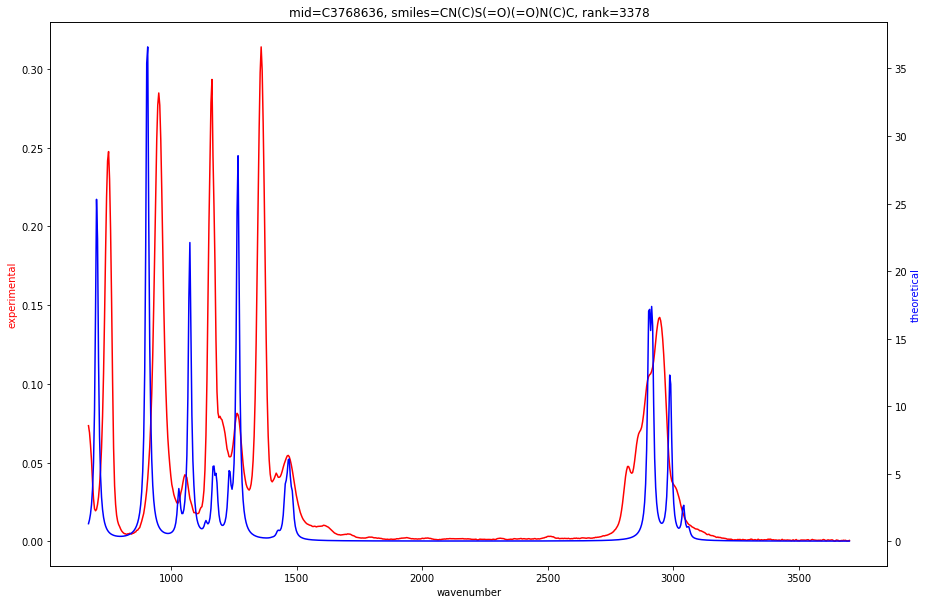

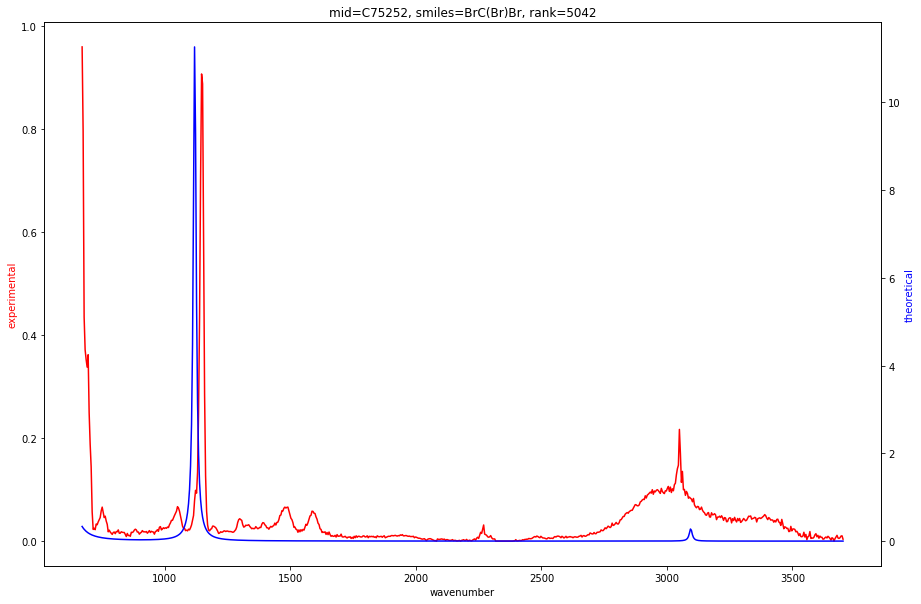

In [22]:
# get good and bad examples
disvec = thexpvec.join(distances.withColumnRenamed('exp_smiles','smiles'),'smiles') \
                 .select('mid','smiles','rank','expvec','thvec') \
                 .dropDuplicates(['smiles'])
selected = disvec.select('mid','smiles','rank',expr('int(2*log(1+rank))').alias('rankrange'),'expvec','thvec')\
                 .dropDuplicates(['rankrange']).sort('rankrange')
selected.show()


# plot
local = selected.collect()
xs = range(670,3706,4)
for row in local:
    mid = row['mid']
    smiles = row['smiles']
    rank = row['rank']
    expvec = row['expvec']
    thvec = row['thvec']
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('wavenumber')
    ax1.set_ylabel('experimental', color='r')
    ax2.set_ylabel('theoretical', color='b')
    plt.title("mid={}, smiles={}, rank={}".format(mid,smiles,rank))
    ax1.plot(xs,expvec,'r',label='experimental')
    ax2.plot(xs,thvec,'b',label='theoretical')
    fig.set_size_inches(15, 10)
    plt.show()

In [23]:
selected.show()
thexpvec.show()
distances.show()

+---------+--------------------+----+---------+--------------------+--------------------+
|      mid|              smiles|rank|rankrange|              expvec|               thvec|
+---------+--------------------+----+---------+--------------------+--------------------+
|  C103059|  CC(C)(O)CCc1ccccc1|   0|        0|[0.06436762924444...|[0.52070387525748...|
|  C592881|           C=CCSCC=C|   1|        1|[0.03134251208038...|[0.06107973521844...|
|  C712505|O=C(c1ccccc1)C1CC...|   2|        2|[0.24325696576091...|[0.98956131088568...|
|C36377590|  CCOc1ccc(CCN)cc1OC|   6|        3|[0.01708340613943...|[0.22519244398579...|
|  C135773|  COc1ccc(OC)c(OC)c1|   7|        4|[0.03067097317510...|[0.28400606714005...|
| C1009116| CCCC(=O)c1ccc(O)cc1|  13|        5|[0.01631046310512...|[0.13018731331211...|
| C3683123|C=C(C)C(=O)OCCc1c...|  22|        6|[0.01967202148253...|[0.63178007116193...|
|   C71410|              CCCCCO|  41|        7|[0.11580837089350...|[0.03034851518717...|
|  C926567

In [24]:
selected_smiles = "COC(=O)C=CC(=O)OC"
selected_dis = distances.filter("exp_smiles=\"{}\"".format(selected_smiles)).dropDuplicates()
selected_vec = selected.filter("smiles=\"{}\"".format(selected_smiles)).dropDuplicates()
selected_dis.show()
selected_vec.show()
item = selected_dis.collect()[0]
itemvec = selected_vec.collect()[0]
dis = item.distance
th = itemvec.thvec
exp = itemvec.expvec
mistakes = zip(item.mistakes,item.distances)

+-----------------+----+-----------------+--------------------+--------------------+
|       exp_smiles|rank|         distance|            mistakes|           distances|
+-----------------+----+-----------------+--------------------+--------------------+
|COC(=O)C=CC(=O)OC|1952|0.559054350701193|[CCOC(=O)CC(CC(=O...|[0.13374905987892...|
+-----------------+----+-----------------+--------------------+--------------------+

+-------+-----------------+----+---------+--------------------+--------------------+
|    mid|           smiles|rank|rankrange|              expvec|               thvec|
+-------+-----------------+----+---------+--------------------+--------------------+
|C624486|COC(=O)C=CC(=O)OC|1952|       15|[0.02692093985488...|[0.53945112883755...|
+-------+-----------------+----+---------+--------------------+--------------------+



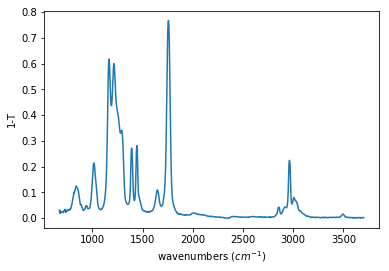

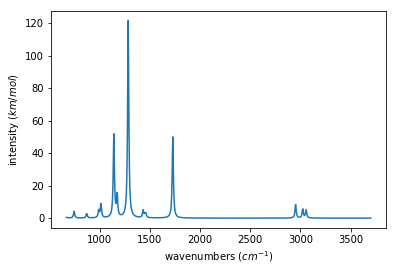

CCOC(=O)CC(CC(=O)OCC)(OC(=O)C)C(=O)OCC 0.13374905987892527


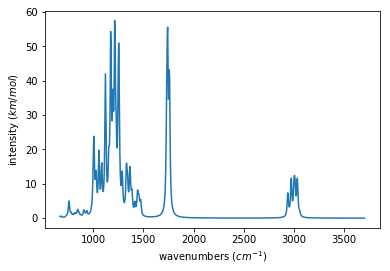

CCCCOC(=O)CC(CC(=O)OCCCC)(OC(=O)C)C(=O)OCCCC 0.13508433652535445


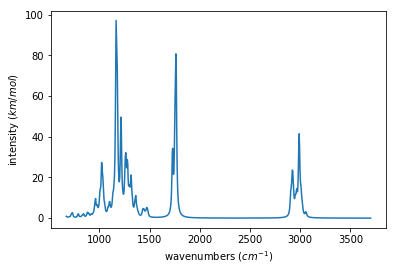

CCOC(=O)C(C(=O)OCC)C(C(=O)OCC)C(=O)OCC 0.16838267289030262


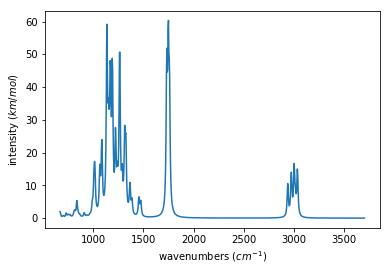

COC(=O)CC(=O)C(F)(F)C(F)(F)F 0.16986056862586585


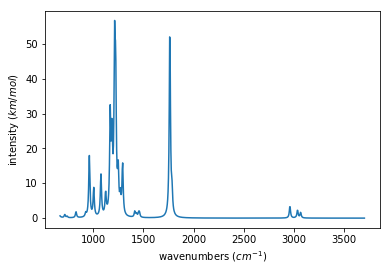

CCOC(=O)CCCCC(=O)OCC 0.172127276240706


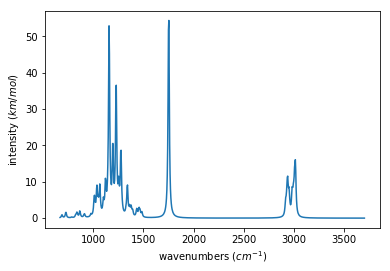

CCOC(=O)CC(=O)C(F)(F)C(F)(F)F 0.1752607862385651


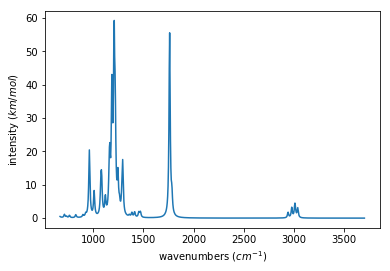

CC12CCC(C(C(=O)C(F)(F)F)C1=O)C2(C)C 0.18270593765383147


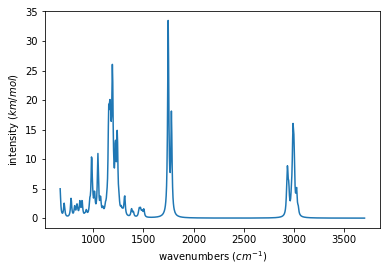

C=CCC(C(=O)OCC)C(=O)OCC 0.18968476931912537


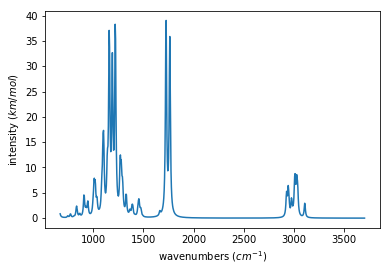

COC(=O)CCSCC(=O)OC 0.19315797102562204


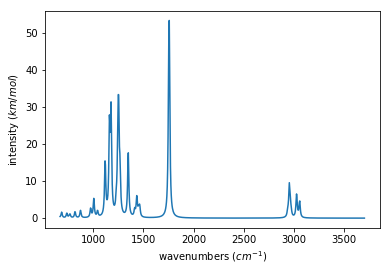

CCOC(=O)C(CCC#N)C(=O)OCC 0.20042716257452287


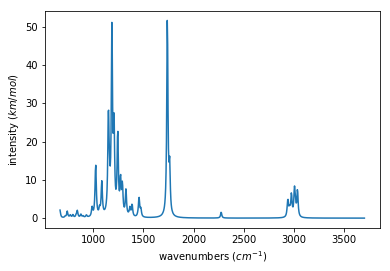

CCOC(=O)C(C(=O)OCC)N1C(=O)c2ccccc2C1=O 0.2035720845292267


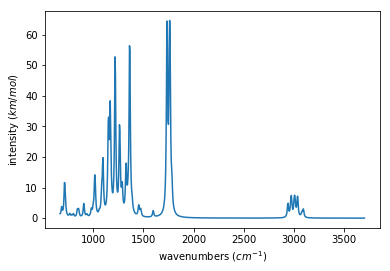

In [25]:
xs = range(670,3706,4)
def plotvec(vec,xlabel=None,ylabel=None):
    plt.plot(xs,vec)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
plotvec(exp,"wavenumbers (${cm}^{-1}$)","1-T")
plotvec(th,"wavenumbers (${cm}^{-1}$)","intensity ($km/mol$)")
    
count = 10
for s,d in mistakes:
    if count < 0:
        break
    else:
        count -= 1
    print(s,d)
    vecdf = thexpvec.filter("smiles=\"{}\"".format(s))
    thfound = vecdf.take(1)[0]
    thvec = thfound.thvec
    plotvec(thvec,"wavenumbers (${cm}^{-1}$)","intensity ($km/mol$)")

In [26]:
list(mistakes)

[('CCOC(=O)CC(O)(CC(=O)OCC)C(=O)OCC', 0.20703065738561133),
 ('CCOC(=O)C(Cl)CCl', 0.20743772975118469),
 ('CCCCCOC(=O)CCC(=O)OCCCCC', 0.20959356983575905),
 ('CCOC(=O)C(Cc1ccccc1)C(=O)OCC', 0.21299970572063742),
 ('COC(=O)CCC(=O)OC', 0.21688264437250349),
 ('COCCOC(=O)CC#N', 0.21770757684280073),
 ('CC12CCC(C(C(=O)C(F)(F)C(F)(F)C(F)(F)F)C1=O)C2(C)C', 0.21881008020828763),
 ('CCOC(=O)C(CC(C)C)C(=O)OCC', 0.2234412302471952),
 ('O=C(Oc1ccc2ccccc2c1)c1ccccc1', 0.22423377840075465),
 ('O=C(n1ccnc1)C(F)(F)F', 0.22695943695323428),
 ('COC(=O)CCCCCC(=O)OC', 0.22716670079124968),
 ('CCOC(=O)CN1C(=O)CSC1=S', 0.22835167619288788),
 ('O=C(C=CC(=O)OCC(F)(F)F)OCC(F)(F)F', 0.2297768302635994),
 ('O=CNc1cccc(C(F)(F)F)c1', 0.23149821292992645),
 ('CC(=O)OCC(C)(COC(=O)C)COC(=O)C', 0.23484888433426232),
 ('CCCOC(=O)CC(O)(CC(=O)OCCC)C(=O)OCCC', 0.23611176370100762),
 ('COC(=O)CC(O)(CC(=O)OC)C(=O)OC', 0.23999547350053574),
 ('COC(=O)CCCCCCCC(=O)OC', 0.24242106018245346),
 ('O=C(Oc1ccccc1)c1ccc(C(=O)Oc2cccc